In [1]:
import sys
from pathlib import Path
curr_path = str(Path().absolute())
parent_path = str(Path().absolute().parent)
sys.path.append(parent_path) # add current terminal path to sys.path

import gym
import datetime

from envs.gridworld_env import CliffWalkingWapper
from QLearning.agent import QLearning
from common.plot import plot_rewards
from common.utils import save_results,make_dir
curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # obtain current time

In [2]:
class QlearningConfig:
    '''训练相关参数'''
    def __init__(self):
        self.algo = 'Qlearning'
        self.env = 'CliffWalking-v0' # 0 up, 1 right, 2 down, 3 left
        self.result_path = curr_path+"/outputs/" +self.env+'/'+curr_time+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env+'/'+curr_time+'/models/'  # path to save models
        self.train_eps = 200 # 训练的episode数目
        self.eval_eps = 30
        self.gamma = 0.9 # reward的衰减率
        self.epsilon_start = 0.95 # e-greedy策略中初始epsilon
        self.epsilon_end = 0.01 # e-greedy策略中的终止epsilon
        self.epsilon_decay = 200 # e-greedy策略中epsilon的衰减率
        self.lr = 0.1 # learning rate

In [3]:
def env_agent_config(cfg,seed=1):
    env = gym.make(cfg.env)  
    env = CliffWalkingWapper(env)
    env.seed(seed)
    state_dim = env.observation_space.n
    action_dim = env.action_space.n
    agent = QLearning(state_dim,action_dim,cfg)
    return env,agent

In [4]:
def train(cfg,env,agent):
    rewards = []  
    ma_rewards = [] # moving average reward
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录每个episode的reward
        state = env.reset()  # 重置环境, 重新开一局（即开始新的一个episode）
        while True:
            action = agent.choose_action(state)  # 根据算法选择一个动作
            next_state, reward, done, _ = env.step(action)  # 与环境进行一次动作交互
            agent.update(state, action, reward, next_state, done)  # Q-learning算法更新
            state = next_state  # 存储上一个观察值
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+ep_reward*0.1)
        else:
            ma_rewards.append(ep_reward)
        if (i_ep+1)%10==0:
            print("Episode:{}/{}: reward:{:.1f}".format(i_ep+1, cfg.train_eps,ep_reward))
    return rewards,ma_rewards

In [5]:
def eval(cfg,env,agent):
    # env = gym.make("FrozenLake-v0", is_slippery=False)  # 0 left, 1 down, 2 right, 3 up
    # env = FrozenLakeWapper(env)
    rewards = []  # 记录所有episode的reward
    ma_rewards = [] # 滑动平均的reward
    for i_ep in range(cfg.eval_eps):
        ep_reward = 0  # 记录每个episode的reward
        state = env.reset()  # 重置环境, 重新开一局（即开始新的一个episode）
        while True:
            action = agent.predict(state)  # 根据算法选择一个动作
            next_state, reward, done, _ = env.step(action)  # 与环境进行一个交互
            state = next_state  # 存储上一个观察值
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+ep_reward*0.1)
        else:
            ma_rewards.append(ep_reward)
        if (i_ep+1)%10==0:
            print(f"Episode:{i_ep+1}/{cfg.eval_eps}, reward:{ep_reward:.1f}")
    return rewards,ma_rewards

Episode:10/200: reward:-287.0
Episode:20/200: reward:-142.0
Episode:30/200: reward:-67.0
Episode:40/200: reward:-61.0
Episode:50/200: reward:-74.0
Episode:60/200: reward:-41.0
Episode:70/200: reward:-55.0
Episode:80/200: reward:-66.0
Episode:90/200: reward:-31.0
Episode:100/200: reward:-31.0
Episode:110/200: reward:-58.0
Episode:120/200: reward:-25.0
Episode:130/200: reward:-18.0
Episode:140/200: reward:-27.0
Episode:150/200: reward:-28.0
Episode:160/200: reward:-25.0
Episode:170/200: reward:-35.0
Episode:180/200: reward:-13.0
Episode:190/200: reward:-22.0
Episode:200/200: reward:-26.0
保存模型成功！
结果保存完毕！


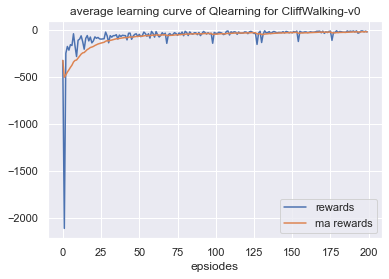

加载模型成功！


In [6]:
cfg = QlearningConfig()
env,agent = env_agent_config(cfg,seed=1)
rewards,ma_rewards = train(cfg,env,agent)
make_dir(cfg.result_path,cfg.model_path)
agent.save(path=cfg.model_path)
save_results(rewards,ma_rewards,tag='train',path=cfg.result_path)
plot_rewards(rewards,ma_rewards,tag="train",env=cfg.env,algo = cfg.algo,path=cfg.result_path)

env,agent = env_agent_config(cfg,seed=10)
agent.load(path=cfg.model_path)
rewards,ma_rewards = eval(cfg,env,agent)
save_results(rewards,ma_rewards,tag='eval',path=cfg.result_path)
plot_rewards(rewards,ma_rewards,tag="eval",env=cfg.env,algo = cfg.algo,path=cfg.result_path)